In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def compute_reconstruction_errors(df, ns=[1,2,3,5,7,10,15]):
    # Keep only numeric columns
    df_num = df.select_dtypes(include=[np.number]).copy()
    df_num = df_num.replace([np.inf, -np.inf], np.nan).fillna(df_num.mode().iloc[0])
    df_num = df_num.loc[:, df_num.var(axis=0) > 0]

    if df_num.shape[1] == 0:
        print("No numeric columns found in dataset.")
        return
    
    X = df_num.values.astype(float)
    n_samples, n_features = X.shape
    mu = X.mean(axis=0, keepdims=True)
    A = X - mu

    # Compute A^T A
    M = A.T @ A
    eigvals, eigvecs = np.linalg.eigh(M)
    idx_desc = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx_desc]
    eigvecs = eigvecs[:, idx_desc]
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0, keepdims=True)
    
    valid_ns = [n for n in ns if n <= n_features and n > 0]
    total_variance = np.sum(eigvals)
    results = []
    for n in valid_ns:
        E = eigvecs[:, :n]
        W = A @ E
        L = W @ E.T
        R = L + mu
        SSE = np.sum((X - R)**2)
        explained = np.sum(eigvals[:n]) / (total_variance if total_variance > 0 else 1.0)
        results.append({
            "n_components": n,
            "n_features": n_features,
            "n_samples": n_samples,
            "reconstruction_SSE": float(SSE),
            "reconstruction_RMSE_per_value": float(np.sqrt(SSE / (n_samples * n_features))),
            "explained_variance_fraction": float(explained)
        })
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    return results_df

In [7]:
def plot_reconstruction_results(results_df):
    # Plot SSE
    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:red'
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Reconstruction SSE', color=color)
    ax1.plot(results_df['n_components'], results_df['reconstruction_SSE'],
             marker='o', color=color, label='SSE')
    ax1.tick_params(axis='y', labelcolor=color)

    # Add a second y-axis for explained variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Explained Variance Fraction', color=color)
    ax2.plot(results_df['n_components'], results_df['explained_variance_fraction'],
             marker='s', color=color, label='Explained Variance')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and grid
    fig.suptitle('Reconstruction Error vs Explained Variance')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show plot
    plt.show()


 n_components  n_features  n_samples  reconstruction_SSE  reconstruction_RMSE_per_value  explained_variance_fraction
            1           6        545        1.825937e+09                     747.255353                     0.999999
            2           6        545        1.012264e+03                       0.556382                     1.000000
            3           6        545        6.126529e+02                       0.432846                     1.000000
            5           6        545        9.122929e+01                       0.167030                     1.000000


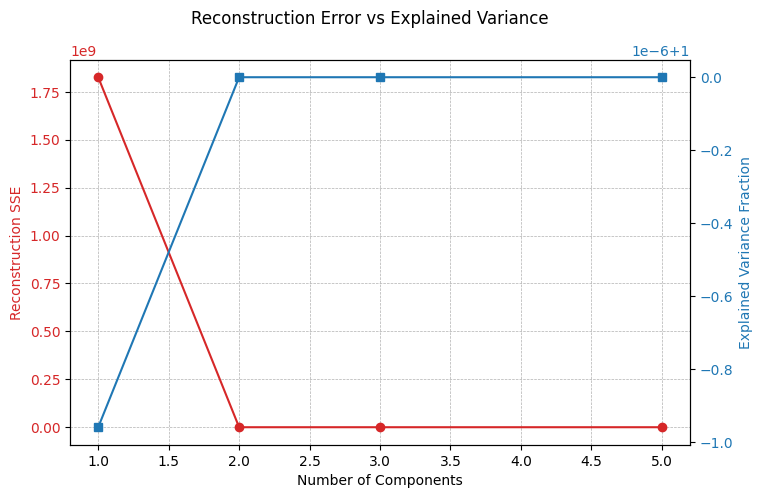

In [8]:
dataset_path = "Data/Housing.csv"
df = pd.read_csv(dataset_path)

results_df = compute_reconstruction_errors(df)
plot_reconstruction_results(results_df)
